In [61]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

try:
    import mplfinance as mpf
except ImportError:
    print("The library is not yet installed. Installing it...")
    ! pip install mplfinance
    import mplfinance as mp
try:
    import yfinance as yf
except ImportError:
    print("The library is not yet installed. Installing it...")
    ! pip install yfinance
    import yfinance as yf

The library is not yet installed. Installing it...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 3.6 MB/s eta 0:00:00 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 2.3 MB/s eta 0:00:00 MB/s eta 0:00:01:02
  Created wheel for peewee: filename=peewee-3.17.8-cp39-cp39-linux_x86_64.whl size=305084 sha256=a5eafde2f5520b679c2e020bbcc3e4bdc59335a2bba265afb50a375464c6d1a7
  Stored in directory: /home/lrizzi17/.cache/pip/wheels/06/b3/7f/ed42a7c83ad89f578928833f5789212c694a015b8bd6a407a1
Successfully built peewee


# Collecting and refining data

We can analyze data from a given dataset stored in memory

In [35]:
# casting the financial data of an arbitrary asset into a pd.DataFrame and performing some initial cleansing
def load_asset(name : str) -> pd.DataFrame :
  data = pd.read_csv(name, sep = "	")
  # data.index is to be interpreted as the time coordinate, measured in hours (hence points are separated by 0.25 h = 15 min)
  # this way, we eliminate the discontinuities in the time coordinate due to the weekend breaks
  data.index = np.arange(0, 0.25*len(data), 0.25)
  data["AbsTime"] = pd.to_datetime(data["<DATE>"] + " " + data["<TIME>"])
  data = data.drop("<TIME>",axis = 1)
  data = data.drop("<DATE>", axis = 1)
  data = data.rename(columns = {"<OPEN>": "Open", "<CLOSE>": "Close", "<HIGH>": "High", "<LOW>":"Low", "<VOL>":"Vol" })
  return data


Or, alternatively, download the dataset by means of the yfinance's python API

In [97]:
def download_asset(ticker_symbol : str, start : str, end : str) -> pd.DataFrame:
    data = yf.download(ticker_symbol, start=start, end=end)
    deltaT = (data.index[1] - data.index[0]).total_seconds() / 3600   #in hours, for homogeneity
    data["AbsTime"] = data.index
    data.index = np.arange(0, deltaT*len(data), deltaT)
    data = data.rename(columns = {"Volume":"Vol" })
    return data



### A first naive plot for the dataset

[*********************100%***********************]  1 of 1 completed


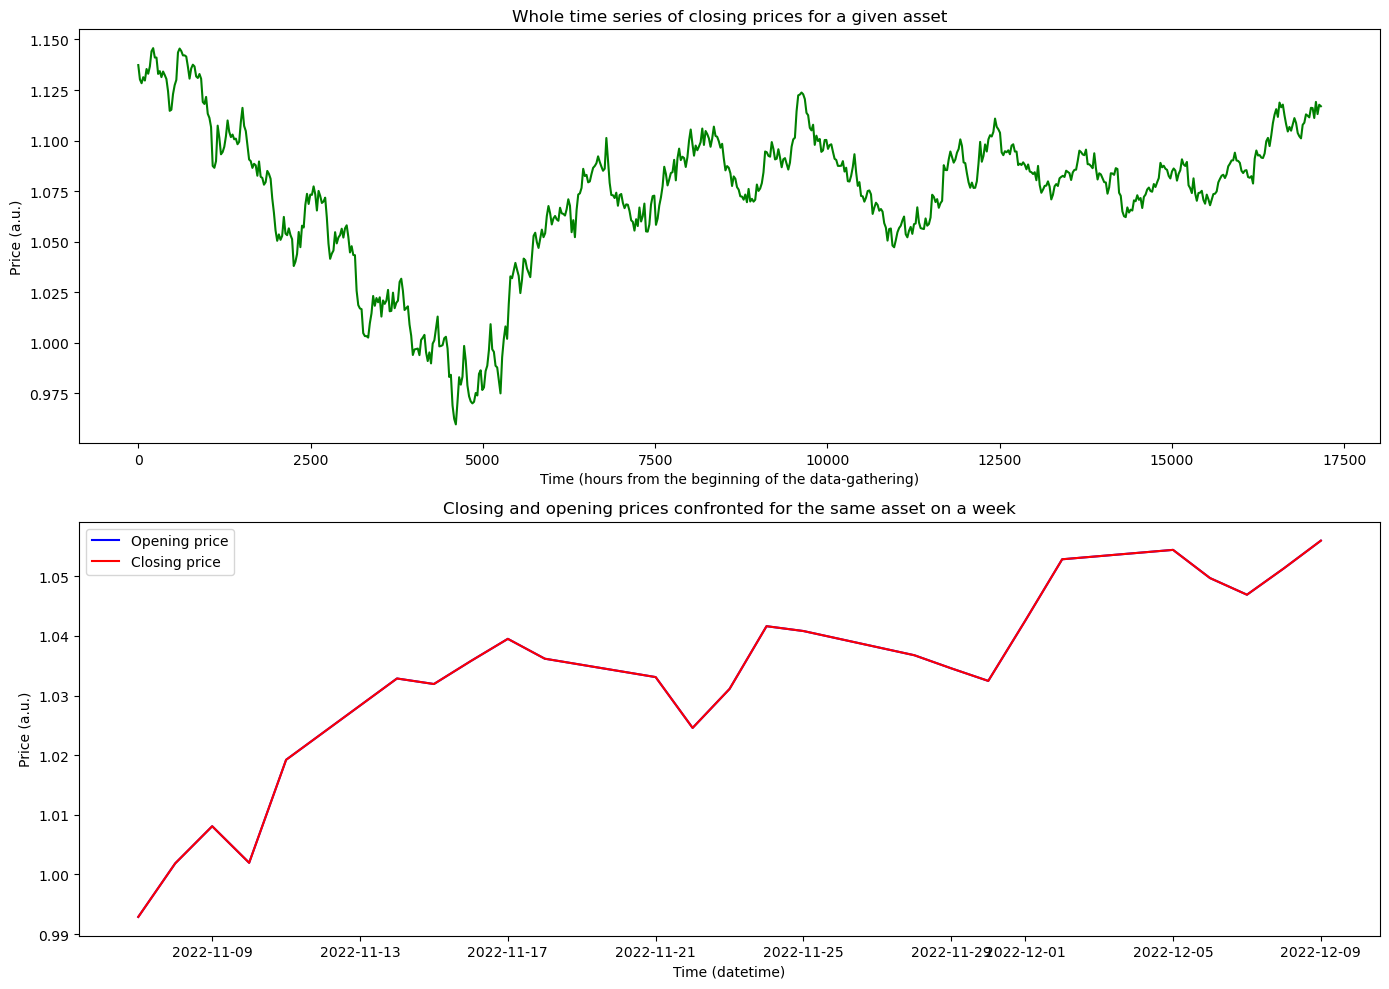

In [102]:
data_DAX = load_asset("DAX_M15_202005242300_202411131015.csv")
data_EURUSD = download_asset("EURUSD=X", start='2022-01-01',end='2024-10-01')

def draw_info(start : str, end : str, data : pd.DataFrame):
    # One can visualize the time series in a naive way by simply plotting the closing price as a function of time
    fig, ax = plt.subplots(ncols = 1, nrows = 2, figsize=(14,10))
    ax[0].plot(data["Close"], c = "g")
    ax[0].set_title("Whole time series of closing prices for a given asset")
    ax[0].set_xlabel("Time (hours from the beginning of the data-gathering)")
    ax[0].set_ylabel("Price (a.u.)")

    # A zoomed view of the same dataset reveals the small differences between closing and opening prices
    # N.B. the plot shows discontinuities due to the weekend breaks, but that's only cause I'm plotting against the columns "AbsTime"
    # which is a datetime object. The actual time coordinate is the index of the DataFrame, which is continuous (and that's what we'll use)
    # Just for this picture, I thought it would have been more meaningful to plot against the datetime object
    filtered_data = data[(data["AbsTime"] > start) & (data["AbsTime"] < end)]
    ax[1].plot(filtered_data["AbsTime"].values, filtered_data["Open"].values, "b", label = "Opening price")
    ax[1].plot(filtered_data["AbsTime"].values, filtered_data["Close"].values, "r", label = "Closing price")
    ax[1].set_title("Closing and opening prices confronted for the same asset on a week")
    ax[1].legend(loc = "best")
    ax[1].set_xlabel("Time (datetime)")
    ax[1].set_ylabel("Price (a.u.)")

    fig.tight_layout()
    plt.show()

draw_info("2022-11-4", "2022-12-11", data_EURUSD)

### Using a candlestick representation

When it comes to financial dataset, it is often useful to visualize those data by means of _ohlc plots_ or _candlestick plots_. We'll use the `mpflfinance` library

In [5]:
# returns a new pd.DataFrame where assets data are interpreted according to Heikin-Ashi candlestick representation
def calculate_heikin_ashi(df):
    ha = df.copy()
    ha['HA_open'] = (df['Open'] + df['Close']) / 2
    ha['HA_high'] = df[['High', 'Open', 'Close']].max(axis=1)
    ha['HA_low'] = df[['Low', 'Open', 'Close']].min(axis=1)
    ha['HA_close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    return ha[["HA_open", "HA_close", "HA_high", "HA_low"]].rename(columns = {"HA_open":"Open", "HA_close": "Close", "HA_low": "Low", "HA_high":"High"})

#candlestick OHLC plot
def plot_OHLC(start : dt.datetime, end : dt.datetime, data : pd.DataFrame):
  fig = mpf.figure(style="yahoo", figsize =(10 , 5))
  ax = fig.add_subplot(1, 1, 1)

  ohlc_data = data.loc[start:end].copy()[["Open", "Close", "High", "Low"]]
  ax.set_title("OHLC candlestick plot")

  mpf.plot(ohlc_data, type= "candle", volume=False, ylabel="", ax=ax)
  plt.tight_layout()
  plt.show()


#plot a simple OHLC plot and superimpose the Heikin-Ashi candles
def plot_OHLC_HA(start : dt.datetime, end : dt.datetime, data : pd.DataFrame):
  fig = mpf.figure(style="yahoo", figsize =(10 , 5))
  ax = fig.add_subplot(1, 1, 1)

  ohlc_data = data.loc[start:end].copy()[["Open", "Close", "High", "Low"]]

  ha_data = calculate_heikin_ashi(ohlc_data)

  addplot = [
        mpf.make_addplot(ha_data, type="candle", secondary_y=False, ax=ax),
  ]
  ax.set_title("Heikin-Ashi candlestick plot")


  mpf.plot(ohlc_data, type= "ohlc", volume=False, ylabel="", ax=ax, addplot = addplot)
  plt.tight_layout()
  plt.show()